# TOC
* [Data collection](#dataCollection)
    * [Retrieve data from Carbon Monitor](#retrieveData)
* [Data preprocessin](#dataPreprocessing)
    * [Prepare the emission dataframe](#emissionDataframe)
    * [Labelling](#labelling)
    * [Convert emissions into matrix](#convertEmission)
    * [Reorder emission matrix](#reorderEmission)
    * [Construct edge_index](#constructEdgeIndex)
    * [Construct edge_attr](#constructEdgeAttr)
* [Modelling construction](#modelling)
    * [Create a dataloader](#createDataloader)
    * [Build the model](#buildModel)
* [Create Train and Evaluation functions](#trainEval)
* [Start training](#training)
* [Test results](#test)
* [Bibliography](#ref)

This assignment collects daily carbon emissions of Chinese provinces from [Carbon Monitor](https://cn.carbonmonitor.org). After preprocessing and labelling, the data is put into **ST-GAT** (Zhang et al., 2019) a Graph Neural Networks (GNNs) model for prediction. The modelling part [Section 4](#modelling) and after was based on [Predicting Los Angeles Traffic with Graphical Neural Networks](https://colab.research.google.com/drive/1NUIQDgj9NXDqtPN_9k_YxKhJN43p3Gho?usp=sharing) which is a Colab version of Zhang et al's work.

Since GNNs requires many packages to be installed beforehand, in case if there is any mismatch that makes some packages fail to be installed in your system, I have restarted Jupyter Kernel and ran all cells with all outputs remained in this notebook. I will also upload another HTMl version which you can refer via [this page](https://palaceparis.github.io/DSAA5020_Assignment1/index.html). The full address is https://palaceparis.github.io/DSAA5020_Assignment1/index.html

# Data collection <a class="anchor" id="dataCollection"></a>

## Retrieve data from [Carbon Monitor](https://cn.carbonmonitor.org) <a class="anchor" id="retrieveData"></a>

In [1]:
import requests
import pandas as pd

# Set the URL of the data to download
url = 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_china'

# Make a GET request to download the data
response = requests.get(url)

# Decode the content of the response as a string
content = response.content.decode('utf-8')

# Convert the string to a StringIO object
from io import StringIO
data = StringIO(content)

# Read the data from the StringIO object into a DataFrame
raw = pd.read_csv(data, delimiter='\t')

In [2]:
raw

,"state,date,sector,value,timestamp"
0,"Anhui,""01/01/2019"",""Residential"",""0.0118734"",""..."
1,"Beijing,""01/01/2019"",""Residential"",""0.300512"",..."
2,"Chongqing,""01/01/2019"",""Residential"",""0"",""1546..."
3,"Fujian,""01/01/2019"",""Residential"",""0"",""1546300..."
4,"Gansu,""01/01/2019"",""Residential"",""0.122791"",""1..."
...,...
226450,"Heilongjiang,""26/09/2022"",""Power"",""0.142754"",""..."
226451,"Heilongjiang,""27/09/2022"",""Power"",""0.144143"",""..."
226452,"Heilongjiang,""28/09/2022"",""Power"",""0.143599"",""..."
226453,"Heilongjiang,""29/09/2022"",""Power"",""0.142346"",""..."


Raw data is collected through simple methods as shown above. They are piled together with ',' as the delimiter. But still, it is easy to see that the data includes provinces and municipalities, date, sectors, corresponding carbon emissions and timestamp. It seems to be recorded from 2019 to 2022.

I am going to use the following variables:

- state
- date
- sector
- value

I expect to label the data by summing the value of all sectors for a province/municipality in each day and predict daily carbon emissions.

# Data prepocessing <a class="anchor" id="dataPreprocessing"></a>

## Prepare the emission dataframe <a class="anchor" id="emissionDataframe"></a>

In [3]:
# split the 'column' column based on "," delimiter
df = raw['state,date,sector,value,timestamp'].str.split(',', expand=True)

# rename the columns
df.columns = ['state', 'date', 'sector', 'value', 'timestamp']

print (df.dtypes)
df

state        object
date         object
sector       object
value        object
timestamp    object
dtype: object


,state,date,sector,value,timestamp
0,Anhui,"""01/01/2019""","""Residential""","""0.0118734""","""1546300800"""
1,Beijing,"""01/01/2019""","""Residential""","""0.300512""","""1546300800"""
2,Chongqing,"""01/01/2019""","""Residential""","""0""","""1546300800"""
3,Fujian,"""01/01/2019""","""Residential""","""0""","""1546300800"""
4,Gansu,"""01/01/2019""","""Residential""","""0.122791""","""1546300800"""
...,...,...,...,...,...
226450,Heilongjiang,"""26/09/2022""","""Power""","""0.142754""","""1664150400"""
226451,Heilongjiang,"""27/09/2022""","""Power""","""0.144143""","""1664236800"""
226452,Heilongjiang,"""28/09/2022""","""Power""","""0.143599""","""1664323200"""
226453,Heilongjiang,"""29/09/2022""","""Power""","""0.142346""","""1664409600"""


In [4]:
df['date'] = df['date'].str.replace('"', '') # remove double quotes
df['sector'] = df['sector'].str.replace('"', '') # remove double quotes
df['value'] = df['value'].str.replace('"', '') # remove double quotes


df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y') # year format
df['value'] = pd.to_numeric(df['value']) # number format

print (df.dtypes)
df

state                object
date         datetime64[ns]
sector               object
value               float64
timestamp            object
dtype: object


,state,date,sector,value,timestamp
0,Anhui,2019-01-01,Residential,0.011873,"""1546300800"""
1,Beijing,2019-01-01,Residential,0.300512,"""1546300800"""
2,Chongqing,2019-01-01,Residential,0.000000,"""1546300800"""
3,Fujian,2019-01-01,Residential,0.000000,"""1546300800"""
4,Gansu,2019-01-01,Residential,0.122791,"""1546300800"""
...,...,...,...,...,...
226450,Heilongjiang,2022-09-26,Power,0.142754,"""1664150400"""
226451,Heilongjiang,2022-09-27,Power,0.144143,"""1664236800"""
226452,Heilongjiang,2022-09-28,Power,0.143599,"""1664323200"""
226453,Heilongjiang,2022-09-29,Power,0.142346,"""1664409600"""


I separate the raw data into different columns and there is still " in some columns so that I am going to remove them and convert *date* and *value* to time value and numeric value respectively.

## Labelling <a class="anchor" id="labelling"></a>

In [5]:
df = df.groupby(['state', 'date'])['value'].sum().reset_index(name='mt_co2_per_day') # emissions from the sum of all sectors
print (df.dtypes)
df

state                     object
date              datetime64[ns]
mt_co2_per_day           float64
dtype: object


,state,date,mt_co2_per_day
0,Anhui,2019-01-01,1.126812
1,Anhui,2019-01-02,1.110479
2,Anhui,2019-01-03,1.078495
3,Anhui,2019-01-04,1.112436
4,Anhui,2019-01-05,1.109971
...,...,...,...
45286,Zhejiang,2022-12-27,1.131461
45287,Zhejiang,2022-12-28,1.140390
45288,Zhejiang,2022-12-29,1.155932
45289,Zhejiang,2022-12-30,1.148535


Since I am going to predict daily carbon emissions for each province/municipality, I sum the value of different sectors and rename it as **mt_co2_per_day**.

In [6]:
df = df[~df['date'].astype(str).str.contains('2019|2020')] # Remove data from 2019 and 2020
df = df.reset_index()
df

,index,state,date,mt_co2_per_day
0,731,Anhui,2021-01-01,1.104406
1,732,Anhui,2021-01-02,1.072344
2,733,Anhui,2021-01-03,1.102166
3,734,Anhui,2021-01-04,1.124868
4,735,Anhui,2021-01-05,1.130247
...,...,...,...,...
22625,45286,Zhejiang,2022-12-27,1.131461
22626,45287,Zhejiang,2022-12-28,1.140390
22627,45288,Zhejiang,2022-12-29,1.155932
22628,45289,Zhejiang,2022-12-30,1.148535


To make the project less complicated, only data from **2021** to **2022** is analyed.

The model we are going to use is **Spatio-Temporal GAT** (Zhang et al., 2019). Basically, I view different province/municipality as nodes in GNNs and whether a pair is adjacent will decide if there is an edge to connect the pair. The physical distance between a pair will be considered in the modelling process. This makes sense because if a province presents a high amount of carbon emissions, adajacent regions will also have a high carbon emission, for example, due to their similar industrial structure. After constructing graphs, the prediction will start.

Therefore, the following data is significant for modelling:

- **emission_matrix** which has daily emissions of each province and municipality.
- **edge_index** which records whether there is an edge between a pair.
- **edge_attr** which is the weight of each edge.
- **distance** which records the physical distance between a pair.

To make this project less complicated, and limited by my knowledge, edge_attr will be set as 1 <a class="anchor" id="edge_attr1"></a>.

## Convert emissions into matrix <a class="anchor" id="convertEmission"></a>

In [7]:
data_mat = df.pivot(index='state', columns='date', values='mt_co2_per_day').reset_index()
data_mat.columns.name = None
data_mat = data_mat.rename_axis(None, axis=1)
data_mat

,state,2021-01-01 00:00:00,2021-01-02 00:00:00,2021-01-03 00:00:00,2021-01-04 00:00:00,2021-01-05 00:00:00,2021-01-06 00:00:00,2021-01-07 00:00:00,2021-01-08 00:00:00,2021-01-09 00:00:00,...,2022-12-22 00:00:00,2022-12-23 00:00:00,2022-12-24 00:00:00,2022-12-25 00:00:00,2022-12-26 00:00:00,2022-12-27 00:00:00,2022-12-28 00:00:00,2022-12-29 00:00:00,2022-12-30 00:00:00,2022-12-31 00:00:00
0,Anhui,1.104406,1.072344,1.102166,1.124868,1.130247,1.145352,1.172693,1.172467,1.158061,...,1.167246,1.160539,1.152805,1.170154,1.184461,1.186461,1.196684,1.212896,1.206869,1.176674
1,Beijing,0.450854,0.429949,0.426838,0.422775,0.439086,0.469905,0.504513,0.489703,0.463729,...,0.444162,0.432418,0.427054,0.432654,0.437076,0.441110,0.448208,0.452960,0.441959,0.424388
2,Chongqing,0.332158,0.323327,0.331921,0.338576,0.339879,0.344031,0.351119,0.350702,0.346666,...,0.353799,0.349190,0.346564,0.353195,0.357809,0.358208,0.361068,0.365990,0.363802,0.355032
3,Fujian,0.676801,0.657805,0.676078,0.690089,0.692958,0.701570,0.717216,0.717082,0.708766,...,0.608838,0.602700,0.598392,0.608901,0.616668,0.617460,0.622511,0.630989,0.627546,0.612257
4,Gansu,0.564246,0.544087,0.553665,0.560191,0.568747,0.586467,0.610626,0.605053,0.589560,...,0.533384,0.528641,0.524420,0.531142,0.537145,0.539352,0.545311,0.552209,0.546581,0.530384
5,Guangdong,1.368663,1.333536,1.367998,1.394865,1.399962,1.416894,1.444565,1.441918,1.425396,...,1.431037,1.407239,1.396019,1.425424,1.444590,1.445898,1.457106,1.476995,1.467223,1.432303
6,Guangxi,0.726092,0.705484,0.725263,0.740398,0.743525,0.752799,0.769857,0.769874,0.760929,...,0.793711,0.788647,0.783369,0.795599,0.805440,0.806648,0.813441,0.824508,0.820544,0.800289
7,Guizhou,0.699381,0.679118,0.698427,0.713144,0.716276,0.725330,0.742295,0.742559,0.733857,...,0.615967,0.611787,0.607661,0.617264,0.624919,0.625851,0.631114,0.639697,0.636559,0.620853
8,Hainan,0.069893,0.068174,0.069877,0.071216,0.071460,0.072314,0.073636,0.073447,0.072610,...,0.075734,0.074239,0.073618,0.075292,0.076329,0.076384,0.076961,0.078012,0.077453,0.075631
9,Hebei,3.102100,2.997442,3.064072,3.111990,3.146780,3.222617,3.335674,3.318484,3.250904,...,2.827842,2.811027,2.790546,2.825926,2.858293,2.867818,2.897319,2.934893,2.911451,2.829608


The emission matrix is available from above. There are 31 provinces/municipalities and 730 consecutive days. 

## Reorder emission matrix <a class="anchor" id="reorderEmission"></a>

In [8]:
url= "https://github.com/palaceparis/DSAA5020_Assignment1/blob/main/New_order_of_provinces.csv?raw=true"
new_order = pd.read_csv(url, header = None)
new_order = new_order[new_order[0] != "Tibet"].reset_index().drop('index', axis=1)
new_order

,0
0,Beijing
1,Tianjin
2,Hebei
3,Shaanxi
4,Inner Mongolia
5,Liaoning
6,Jilin
7,Heilongjiang
8,Shanghai
9,Jiangsu


In [9]:
data_mat.set_index('state', inplace=True) # Set states as index
data_mat = data_mat.drop(['Tibet'], axis=0) # Remove Tibet for easier illustration
data_mat

,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
state,,,,,,,,,,,,,,,,,,,,,
Anhui,1.104406,1.072344,1.102166,1.124868,1.130247,1.145352,1.172693,1.172467,1.158061,1.160492,...,1.167246,1.160539,1.152805,1.170154,1.184461,1.186461,1.196684,1.212896,1.206869,1.176674
Beijing,0.450854,0.429949,0.426838,0.422775,0.439086,0.469905,0.504513,0.489703,0.463729,0.451533,...,0.444162,0.432418,0.427054,0.432654,0.437076,0.441110,0.448208,0.452960,0.441959,0.424388
Chongqing,0.332158,0.323327,0.331921,0.338576,0.339879,0.344031,0.351119,0.350702,0.346666,0.347760,...,0.353799,0.349190,0.346564,0.353195,0.357809,0.358208,0.361068,0.365990,0.363802,0.355032
Fujian,0.676801,0.657805,0.676078,0.690089,0.692958,0.701570,0.717216,0.717082,0.708766,0.710699,...,0.608838,0.602700,0.598392,0.608901,0.616668,0.617460,0.622511,0.630989,0.627546,0.612257
Gansu,0.564246,0.544087,0.553665,0.560191,0.568747,0.586467,0.610626,0.605053,0.589560,0.585315,...,0.533384,0.528641,0.524420,0.531142,0.537145,0.539352,0.545311,0.552209,0.546581,0.530384
Guangdong,1.368663,1.333536,1.367998,1.394865,1.399962,1.416894,1.444565,1.441918,1.425396,1.430285,...,1.431037,1.407239,1.396019,1.425424,1.444590,1.445898,1.457106,1.476995,1.467223,1.432303
Guangxi,0.726092,0.705484,0.725263,0.740398,0.743525,0.752799,0.769857,0.769874,0.760929,0.762939,...,0.793711,0.788647,0.783369,0.795599,0.805440,0.806648,0.813441,0.824508,0.820544,0.800289
Guizhou,0.699381,0.679118,0.698427,0.713144,0.716276,0.725330,0.742295,0.742559,0.733857,0.735640,...,0.615967,0.611787,0.607661,0.617264,0.624919,0.625851,0.631114,0.639697,0.636559,0.620853
Hainan,0.069893,0.068174,0.069877,0.071216,0.071460,0.072314,0.073636,0.073447,0.072610,0.072882,...,0.075734,0.074239,0.073618,0.075292,0.076329,0.076384,0.076961,0.078012,0.077453,0.075631


In [10]:
data_mat = data_mat.reindex(new_order[0])
data_mat

,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
0,,,,,,,,,,,,,,,,,,,,,
Beijing,0.450854,0.429949,0.426838,0.422775,0.439086,0.469905,0.504513,0.489703,0.463729,0.451533,...,0.444162,0.432418,0.427054,0.432654,0.437076,0.441110,0.448208,0.452960,0.441959,0.424388
Tianjin,0.636382,0.610205,0.615827,0.618550,0.633505,0.662627,0.699172,0.687893,0.662989,0.653187,...,0.620317,0.613897,0.608382,0.614586,0.620950,0.624870,0.633161,0.640672,0.631359,0.610009
Hebei,3.102100,2.997442,3.064072,3.111990,3.146780,3.222617,3.335674,3.318484,3.250904,3.238950,...,2.827842,2.811027,2.790546,2.825926,2.858293,2.867818,2.897319,2.934893,2.911451,2.829608
Shaanxi,1.040251,1.003557,1.021814,1.034394,1.049505,1.081041,1.124378,1.114689,1.087045,1.079846,...,1.052822,1.044696,1.036680,1.050047,1.062019,1.065959,1.077317,1.091117,1.081128,1.049927
Inner Mongolia,1.818188,1.754463,1.792741,1.819838,1.842251,1.889927,1.960770,1.949930,1.907740,1.898701,...,1.945186,1.940960,1.927670,1.948057,1.969502,1.976668,1.997668,2.023484,2.008339,1.950909
Liaoning,1.684601,1.616690,1.633553,1.642542,1.680061,1.753591,1.846656,1.818705,1.755675,1.731695,...,1.618128,1.601132,1.586883,1.603878,1.620735,1.630478,1.651617,1.671379,1.647902,1.593102
Jilin,0.657763,0.629498,0.631960,0.631930,0.650150,0.685154,0.727203,0.712322,0.682574,0.669900,...,0.601154,0.591169,0.585084,0.591730,0.597834,0.602263,0.610894,0.617851,0.606572,0.584707
Heilongjiang,0.699359,0.668283,0.668834,0.667004,0.688262,0.728784,0.776605,0.758793,0.724469,0.709232,...,0.707474,0.695695,0.688457,0.695985,0.703066,0.708487,0.718852,0.726963,0.713298,0.687184
Shanghai,0.332567,0.323498,0.332275,0.339041,0.340393,0.344585,0.351954,0.351699,0.347637,0.348666,...,0.322755,0.318909,0.316557,0.322425,0.326598,0.326983,0.329619,0.334111,0.332179,0.324140


In this section, I introduce a new order, reset the index of emission matrix and remove "Tibet" from the dataset. The new order is actually from Figure 1 (Cao et al., 2017) which shows the adjacency information of 31 provinces and cities in China. This order is also used to build edge_index and edge_attr. Again, to make this project less complicated, Tibet is removed with a total of 30 provinces/municipalities left.

<figure>
<img src="https://raw.githubusercontent.com/palaceparis/DSAA5020_Assignment1/main/Geographical-adjacency-information-of-31-provinces-and-cities-in-China_W640.jpg" style="width:80%">
<figcaption align = "center"> Figure 1. Geographical adjacency information of 31 provinces and cities in China. </figcaption>
</figure>


In [11]:
import numpy as np
# np.transpose(data_mat).to_csv('emissions.csv', index=False, header=False) # write to CSV and upload it onto GitHub for further use.

## Construct edge_index <a class="anchor" id="constructEdgeIndex"></a>

In [12]:
url= "https://github.com/palaceparis/DSAA5020_Assignment1/blob/main/adjacency_information%20.csv?raw=true"
raw_edge = pd.read_csv(url)
print(raw_edge.dtypes)
raw_edge

province     object
x1            int64
x2          float64
x3          float64
x4          float64
x5          float64
x6          float64
x7          float64
x8          float64
dtype: object


,province,x1,x2,x3,x4,x5,x6,x7,x8
0,Beijing,2,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Tianjin,1,3.0,15.0,NaN,NaN,NaN,NaN,NaN
2,Hebei,1,2.0,4.0,5.0,6.0,15.0,16.0,NaN
3,Shaanxi,3,5.0,16.0,27.0,NaN,NaN,NaN,NaN
4,Inner Mongolia,3,4.0,6.0,7.0,8.0,27.0,28.0,30.0
5,Liaoning,3,5.0,7.0,NaN,NaN,NaN,NaN,NaN
6,Jilin,5,6.0,8.0,NaN,NaN,NaN,NaN,NaN
7,Heilongjiang,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Shanghai,10,11.0,NaN,NaN,NaN,NaN,NaN,NaN
9,Jiangsu,9,11.0,12.0,15.0,NaN,NaN,NaN,NaN


The adajacency information is read into Python as shown above. We can know from it that, for example, Beijing is adjacent to Tianjin and Hebei. Same for others.

In [13]:
# create a dictionary to map province names to indices
index_to_province = {i: province for i, province in enumerate(raw_edge['province'])}
index_to_province = {i+1: province for i, province in enumerate(raw_edge['province'])} # Add one to dic
# replace province names with their indices in the raw_edge dataframe
for i in range(31):
    if pd.notnull(raw_edge.loc[i, 'x1']):
        raw_edge.loc[i, 'x1'] = index_to_province[raw_edge.loc[i, 'x1']]
    if pd.notnull(raw_edge.loc[i, 'x2']):
        raw_edge.loc[i, 'x2'] = index_to_province[raw_edge.loc[i, 'x2']]
    if pd.notnull(raw_edge.loc[i, 'x3']):
        raw_edge.loc[i, 'x3'] = index_to_province[raw_edge.loc[i, 'x3']]
    if pd.notnull(raw_edge.loc[i, 'x4']):
        raw_edge.loc[i, 'x4'] = index_to_province[raw_edge.loc[i, 'x4']]
    if pd.notnull(raw_edge.loc[i, 'x5']):
        raw_edge.loc[i, 'x5'] = index_to_province[raw_edge.loc[i, 'x5']]
    if pd.notnull(raw_edge.loc[i, 'x6']):
        raw_edge.loc[i, 'x6'] = index_to_province[raw_edge.loc[i, 'x6']]
    if pd.notnull(raw_edge.loc[i, 'x7']):
        raw_edge.loc[i, 'x7'] = index_to_province[raw_edge.loc[i, 'x7']]
    if pd.notnull(raw_edge.loc[i, 'x8']):
        raw_edge.loc[i, 'x8'] = index_to_province[raw_edge.loc[i, 'x8']]

edge_index = pd.DataFrame(0, index=raw_edge["province"], columns=raw_edge["province"])
for i in range(31):
    for j in range(1, 9):
        if pd.isna(raw_edge.iloc[i, j]):
            pass
        else:
            edge_index.loc[raw_edge.iloc[i, 0], raw_edge.iloc[i, j]] = 1


edge_index = edge_index.drop("Tibet").drop(columns=["Tibet"])
edge_index

province,Beijing,Tianjin,Hebei,Shaanxi,Inner Mongolia,Liaoning,Jilin,Heilongjiang,Shanghai,Jiangsu,...,Hainan,Sichuan,Chongqing,Guizhou,Yunnan,Shanxi,Gansu,Qinghai,Ningxia,Xinjiang
province,,,,,,,,,,,,,,,,,,,,,
Beijing,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tianjin,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hebei,1,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shaanxi,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Inner Mongolia,0,0,1,1,0,1,1,1,0,0,...,0,0,0,0,0,1,1,0,1,0
Liaoning,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jilin,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Heilongjiang,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shanghai,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


The above shows the edge_index matrix. 1 means adjacent and 0 otherwise. 

In [14]:
from igraph import Graph
edge_index = edge_index.values
g = Graph.Adjacency(edge_index.tolist())
edge_index = g.get_edgelist()
edge_index = np.transpose(edge_index)
edge_index

array([[ 0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,
         8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
        11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15,
        15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
        17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 20, 21, 21, 21, 21, 21,
        22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25,
        25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 28,
        28, 28, 29, 29],
       [ 1,  2,  0,  2, 14,  0,  1,  3,  4,  5, 14, 15,  2,  4, 15, 25,
         2,  3,  5,  6,  7, 25, 26, 28,  2,  4,  6,  4,  5,  7,  4,  6,
         9, 10,  8, 10, 11, 14,  8,  9, 11, 12, 13,  9, 10, 13, 14, 15,
        16, 10, 13, 18, 10, 11, 12, 16, 17, 18,  1,  2,  9, 11, 15,  2,
         3, 11, 14, 16, 25, 11, 13, 15, 17, 21, 25, 13, 16, 18, 19, 21,
        23, 12, 13, 17, 19, 20, 17, 18,

Finally, we convert the matrix into array so that GNNs could read later.

In [15]:
# pd.DataFrame(edge_index).to_csv('edge_index.csv', index=False, header=False) # write to CSV and upload it onto GitHub for further use.

## Construct edge_attr <a class="anchor" id="constructEdgeAttr"></a>

In [16]:
import numpy as np
edge_attr = pd.DataFrame(np.ones((len(edge_index),1)),columns=['Value'])
edge_attr

,Value
0,1.0
1,1.0


As explained in [Section 2.1](#edge_attr1), the value of edge_attr will be 1.

In [17]:
# edge_attr.to_csv('edge_attr.csv', index=False, header=False) # write to CSV and upload it onto GitHub for further use.

The following parts from [Section 4](#modelling) to [Section 6](#training) are based on Zhang et al's work in 2019. I made adjustments accordingly. Basically, [Section 4.1](#creatDataloader) creats a dataloader based on emission_matrix, edge_matrix, edge_attr and distance I consutructed before. Then the model is proposed based on their paper. Finally, a prediction test is conducted.

Currently, due to my limited knowledge, there is not much to explain. You can skip to [Section 7](#test) where prediction performance is plotted for the 30 provinces/municipalities.

# Modelling construction <a class="anchor" id="modelling"></a>

## Create a dataloader <a class="anchor" id="creatDataloader"></a>

In [18]:
import torch
import numpy as np
import pandas as pd
import os
from torch_geometric.data import InMemoryDataset, Data
from shutil import copyfile


def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    """"
    Given distances between all nodes, convert into a weight matrix
    :param W distances
    :param sigma2 User configurable parameter to adjust sparsity of matrix
    :param epsilon User configurable parameter to adjust sparsity of matrix
    :param gat_version If true, use 0/1 weights with self loops. Otherwise, use float
    """
    n = W.shape[0]
    W = W / 10000.
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    # refer to Eq.10
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    # If using the gat version of this, round to 0/1 and include self loops
    if gat_version:
        W[W>0] = 1
        W += np.identity(n)


    return W

class CarbonDataset(InMemoryDataset):
    """
    Dataset for Graph Neural Networks.
    """
    def __init__(self, config, W, root='', transform=None, pre_transform=None):
        self.config = config
        self.W = W
        super().__init__(root, transform, pre_transform)
        self.data, self.slices, self.n_node, self.mean, self.std_dev = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, 'emissions.csv')]

    @property
    def processed_file_names(self):
        return ['./data.pt']

    def download(self):
        url = 'https://github.com/palaceparis/DSAA5020_Assignment1/blob/main/emissions.csv?raw=true'
        response = requests.get(url)
        with open(os.path.join(self.raw_dir, 'emissions.csv'), 'wb') as f:
            f.write(response.content)
#         copyfile('/Users/tonygong/Documents/GitHub/DSAA5020_Assignment1/emissions.csv', os.path.join(self.raw_dir, 'emissions.csv'))

    def process(self):
        """
        Process the raw datasets into saved .pt dataset for later use.
        Note that any self.fields here wont exist if loading straight from the .pt file
        """
        # Data Preprocessing and loading
        data = pd.read_csv(self.raw_file_names[0], header=None).values
        # Technically using the validation and test datasets here, but it's fine, would normally get the
        # mean and std_dev from a large dataset
        mean =  np.mean(data)
        std_dev = np.std(data)
        data = z_score(data, np.mean(data), np.std(data))
        
        _, n_node = data.shape
        n_window = self.config['N_PRED'] + self.config['N_HIST']

        edge_index = pd.read_csv('https://github.com/palaceparis/DSAA5020_Assignment1/blob/main/edge_index.csv?raw=true', header=None).values
        edge_index = torch.tensor(edge_index)
        edge_attr = pd.read_csv('https://github.com/palaceparis/DSAA5020_Assignment1/blob/main/edge_attr.csv?raw=true', header=None).values
        edge_attr = torch.tensor(edge_attr)
        num_edges = 132



        sequences = []

        # T x F x N
        for i in range(self.config['N_SLOT']):
            # for each time point construct a different graph with data object
            # Docs here: https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
            g = Data()
            g.__num_nodes__ = n_node

            g.edge_index = edge_index
            g.edge_attr  = edge_attr

            # (F,N) switched to (N,F)
            sta = i 
            end = sta + n_window
            # [21, 228]
            full_window = np.swapaxes(data[sta:end, :], 0, 1)
            g.x = torch.FloatTensor(full_window[:, 0:self.config['N_HIST']])
            g.y = torch.FloatTensor(full_window[:, self.config['N_HIST']::])
            sequences += [g]

        # Make the actual dataset
        data, slices = self.collate(sequences)

        torch.save((data, slices, n_node, mean, std_dev), self.processed_paths[0])

def get_splits(dataset: CarbonDataset, n_slot, splits):
    """
    Given the data, split it into random subsets of train, val, and test as given by splits
    :param dataset: CarbonDataset object to split
    :param n_slot: Number of possible sliding windows in a day
    :param splits: (train, val, test) ratios
    """
    split_train, split_val, _ = splits
    i = split_train
    j = split_val
    train = dataset[:i]
    val = dataset[i:i+j]
    test = dataset[i+j:]

    return train, val, test

## Build the model <a class="anchor" id="buildModel"></a>

In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
class ST_GAT(torch.nn.Module):
    """
    Spatio-Temporal Graph Attention Network as presented in https://ieeexplore.ieee.org/document/8903252
    """
    def __init__(self, in_channels, out_channels, n_nodes, heads=8, dropout=0.0):
        """
        Initialize the ST-GAT model
        :param in_channels Number of input channels
        :param out_channels Number of output channels
        :param n_nodes Number of nodes in the graph
        :param heads Number of attention heads to use in graph
        :param dropout Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        self.n_preds = 2
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        # single graph attentional layer with 8 attention heads
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0, concat=False)

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)

        # fully-connected neural network
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x, edge_index = data.x, data.edge_index
        # apply dropout
        if device == 'cpu':
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)

        # gat layer: output of gat: [11400, 12]
        x = self.gat(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)

        # RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        # [12, 50, 228] -> [12, 50, 32]
        x, _ = self.lstm1(x)
        # [12, 50, 32] -> [12, 50, 128]
        x, _ = self.lstm2(x)

        # Output contains h_t for each timestep, only the last one has all input's accounted for
        # [12, 50, 128] -> [50, 128]
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linear(x)

        # Now reshape into final output
        s = x.shape
        # [50, 228*9] -> [50, 228, 9]
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))
        # [50, 228, 9] ->  [11400, 9]
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))
        return x


# Create Train and Evaluation functions <a class="anchor" id="trainEval"></a>

In [20]:
@torch.no_grad()
def eval(model, device, dataloader, type=''):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """
    model.eval()
    model.to(device)

    mae = 0
    rmse = 0
    mape = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
            truth = un_z_score(truth, dataloader.dataset.mean, dataloader.dataset.std_dev)
            pred = un_z_score(pred, dataloader.dataset.mean, dataloader.dataset.std_dev)
            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth
            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            mape += MAPE(truth, pred)
            n += 1
    rmse, mae, mape = rmse / n, mae / n, mape / n

    print(f'{type}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

    #get the average score for each metric in each batch
    return rmse, mae, mape, y_pred, y_truth

def train(model, device, dataloader, optimizer, loss_fn, epoch):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param optimizer Optimizer to use
    :param loss_fn Loss function
    :param epoch Current epoch
    """
    model.train()
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn()(y_pred.float(), torch.squeeze(batch.y).float())
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

    return loss

In [21]:
def z_score(x, mean, std):
    """
    Z-score normalization function: $z = (X - \mu) / \sigma $,
    where z is the z-score, X is the value of the element,
    $\mu$ is the population mean, and $\sigma$ is the standard deviation.
    :param x: torch array, input array to be normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    :return: torch array, z-score normalized array.
    """
    return (x - mean) / std

def un_z_score(x_normed, mean, std):
    """
    Undo the Z-score calculation
    :param x_normed: torch array, input array to be un-normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    """
    return x_normed * std  + mean


def MAPE(v, v_):
    """
    Mean absolute percentage error, given as a % (e.g. 99 -> 99%)
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAPE averages on all elements of input.
    """
    return torch.mean(torch.abs((v_ - v)) /(v + 1e-15) * 100)


def RMSE(v, v_):
    """
    Mean squared error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, RMSE averages on all elements of input.
    """
    return torch.sqrt(torch.mean((v_ - v) ** 2))


def MAE(v, v_):
    """
    Mean absolute error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAE averages on all elements of input.
    """
    return torch.mean(torch.abs(v_ - v))


In [22]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

# Make a tensorboard writer
writer = SummaryWriter()

def model_train(train_dataloader, val_dataloader, config, device):
    """
    Train the ST-GAT model. Evaluate on validation dataset as you go.
    :param train_dataloader Data loader of training dataset
    :param val_dataloader Dataloader of val dataset
    :param config configuration to use
    :param device Device to evaluate on
    """

    # Make the model. Each datapoint in the graph is 228x12: N x F (N = # nodes, F = time window)
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT']) 
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_fn = torch.nn.MSELoss

    model.to(device)

    # For every epoch, train the model on training dataset. Evaluate model on validation dataset
    for epoch in range(config['EPOCHS']):
        loss = train(model, device, train_dataloader, optimizer, loss_fn, epoch)
        print(f"Loss: {loss:.3f}")
        if epoch % 5 == 0:
            train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_dataloader, 'Train')
            val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_dataloader, 'Valid')
            writer.add_scalar(f"MAE/train", train_mae, epoch)
            writer.add_scalar(f"RMSE/train", train_rmse, epoch)
            writer.add_scalar(f"MAPE/train", train_mape, epoch)
            writer.add_scalar(f"MAE/val", val_mae, epoch)
            writer.add_scalar(f"RMSE/val", val_rmse, epoch)
            writer.add_scalar(f"MAPE/val", val_mape, epoch)

    writer.flush()
    # Save the model
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            }, os.path.join(config["CHECKPOINT_DIR"], f"model_{timestr}.pt"))

    return model

def model_test(model, test_dataloader, device, config):
    """
    Test the ST-GAT model
    :param test_dataloader Data loader of test dataset
    :param device Device to evaluate on
    """
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')


2023-03-09 23:23:12.845005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Start training <a class="anchor" id="training"></a>

In [23]:
from torch_geometric.loader import DataLoader

# Constant config to use throughout
config = {
    'BATCH_SIZE': 7,
    'EPOCHS': 100, # 60 default
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'CHECKPOINT_DIR': './runs',
    'N_PRED': 2,
    'N_HIST': 4,
    'DROPOUT': 0.2,
    # # number of possible 5 minute measurements per day
    # 'N_DAY_SLOT': 288,
    # # number of days worth of data in the dataset
    # 'N_DAYS': 44,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': 30,
}
# Number of possible windows in a day
config['N_SLOT']= 730 - (config['N_PRED']+config['N_HIST']) + 1

# Load the weight and dataset dataset
distances = pd.read_csv('https://github.com/palaceparis/DSAA5020_Assignment1/blob/main/distance.csv?raw=true', header=None).values
W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])
dataset = CarbonDataset(config, W)

Processing...
Done!


In [24]:
# total of 44 days in the dataset, use 34 for training, 5 for val, 5 for test
d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (430, 150, 150))
train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)

# Get gpu if you can
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

# Configure and train model
config['N_NODE'] = dataset.n_node
model = model_train(train_dataloader, val_dataloader, config, device)

Using cpu


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 63.87it/s]


Loss: 0.226
Train, MAE: 0.21298879384994507, RMSE: 0.34053006768226624, MAPE: 35.5572395324707
Valid, MAE: 0.20336931943893433, RMSE: 0.3244883716106415, MAPE: 37.10847091674805


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 125.08it/s]


Loss: 0.012


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 133.72it/s]


Loss: 0.014


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 121.66it/s]


Loss: 0.033


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 140.55it/s]


Loss: 0.018


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 108.38it/s]


Loss: 0.029
Train, MAE: 0.07708524167537689, RMSE: 0.10023961216211319, MAPE: 12.306187629699707
Valid, MAE: 0.08447971940040588, RMSE: 0.10416876524686813, MAPE: 14.777859687805176


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 136.73it/s]


Loss: 0.015


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 138.72it/s]


Loss: 0.019


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 140.91it/s]


Loss: 0.034


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 142.69it/s]


Loss: 0.033


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 139.61it/s]


Loss: 0.010
Train, MAE: 0.07010913640260696, RMSE: 0.09150727093219757, MAPE: 10.89659595489502
Valid, MAE: 0.07942652702331543, RMSE: 0.09978576004505157, MAPE: 13.587172508239746


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 123.12it/s]


Loss: 0.009


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 127.02it/s]


Loss: 0.022


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 117.56it/s]


Loss: 0.013


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 120.33it/s]


Loss: 0.013


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 140.83it/s]


Loss: 0.024
Train, MAE: 0.0584678016602993, RMSE: 0.08114822208881378, MAPE: 7.658558368682861
Valid, MAE: 0.06397571414709091, RMSE: 0.08895318955183029, MAPE: 8.849929809570312


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 143.36it/s]


Loss: 0.016


Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 138.55it/s]


Loss: 0.005


Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 135.00it/s]


Loss: 0.012


Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 138.65it/s]


Loss: 0.011


Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 141.83it/s]


Loss: 0.014
Train, MAE: 0.056010838598012924, RMSE: 0.07783005386590958, MAPE: 7.509891986846924
Valid, MAE: 0.06754766404628754, RMSE: 0.09300094097852707, MAPE: 9.384190559387207


Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 141.23it/s]


Loss: 0.010


Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 155.99it/s]


Loss: 0.007


Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 146.54it/s]


Loss: 0.009


Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 126.33it/s]


Loss: 0.017


Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 147.75it/s]


Loss: 0.006
Train, MAE: 0.04165681451559067, RMSE: 0.06152362748980522, MAPE: 5.024341583251953
Valid, MAE: 0.05959400162100792, RMSE: 0.08345279842615128, MAPE: 8.12752914428711


Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 154.85it/s]


Loss: 0.006


Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 152.64it/s]


Loss: 0.006


Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 145.07it/s]


Loss: 0.004


Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 117.18it/s]


Loss: 0.006


Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 139.42it/s]


Loss: 0.007
Train, MAE: 0.04043687880039215, RMSE: 0.05934949591755867, MAPE: 4.972799777984619
Valid, MAE: 0.059825360774993896, RMSE: 0.08435830473899841, MAPE: 8.078770637512207


Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 153.45it/s]


Loss: 0.015


Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 134.88it/s]


Loss: 0.010


Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 143.43it/s]


Loss: 0.008


Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 145.43it/s]


Loss: 0.006


Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 132.71it/s]


Loss: 0.017
Train, MAE: 0.04135550931096077, RMSE: 0.059631939977407455, MAPE: 5.6436920166015625
Valid, MAE: 0.06289664655923843, RMSE: 0.08585068583488464, MAPE: 9.284286499023438


Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 147.53it/s]


Loss: 0.007


Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 141.99it/s]


Loss: 0.004


Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 136.94it/s]


Loss: 0.024


Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 117.90it/s]


Loss: 0.005


Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 103.67it/s]


Loss: 0.007
Train, MAE: 0.03971622884273529, RMSE: 0.05843742564320564, MAPE: 4.792421340942383
Valid, MAE: 0.06115828454494476, RMSE: 0.08529291301965714, MAPE: 8.410019874572754


Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 116.54it/s]


Loss: 0.005


Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 139.82it/s]


Loss: 0.007


Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 128.27it/s]


Loss: 0.007


Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 119.78it/s]


Loss: 0.007


Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 130.51it/s]


Loss: 0.010
Train, MAE: 0.04026702418923378, RMSE: 0.05947375297546387, MAPE: 4.77850866317749
Valid, MAE: 0.05787782371044159, RMSE: 0.082197405397892, MAPE: 7.819253921508789


Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 129.11it/s]


Loss: 0.005


Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 140.77it/s]


Loss: 0.008


Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 131.78it/s]


Loss: 0.005


Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 147.33it/s]


Loss: 0.005


Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 152.67it/s]


Loss: 0.007
Train, MAE: 0.04172844812273979, RMSE: 0.06129501760005951, MAPE: 5.388225078582764
Valid, MAE: 0.05994986370205879, RMSE: 0.08553911000490189, MAPE: 8.46329116821289


Epoch 51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 150.63it/s]


Loss: 0.008


Epoch 52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 154.08it/s]


Loss: 0.006


Epoch 53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 156.76it/s]


Loss: 0.006


Epoch 54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 148.99it/s]


Loss: 0.008


Epoch 55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 130.05it/s]


Loss: 0.007
Train, MAE: 0.03933577239513397, RMSE: 0.05758750066161156, MAPE: 4.8746747970581055
Valid, MAE: 0.059484124183654785, RMSE: 0.0834156796336174, MAPE: 8.336132049560547


Epoch 56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 151.67it/s]


Loss: 0.008


Epoch 57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 146.02it/s]


Loss: 0.007


Epoch 58: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 135.91it/s]


Loss: 0.006


Epoch 59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 135.99it/s]


Loss: 0.007


Epoch 60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 116.73it/s]


Loss: 0.007
Train, MAE: 0.04041032865643501, RMSE: 0.05991823598742485, MAPE: 4.932921886444092
Valid, MAE: 0.060036882758140564, RMSE: 0.08421707898378372, MAPE: 8.169648170471191


Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 94.73it/s]


Loss: 0.010


Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 97.49it/s]


Loss: 0.007


Epoch 63: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 135.66it/s]


Loss: 0.008


Epoch 64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 152.30it/s]


Loss: 0.007


Epoch 65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 154.55it/s]


Loss: 0.008
Train, MAE: 0.03894921764731407, RMSE: 0.05744703486561775, MAPE: 4.599898338317871
Valid, MAE: 0.057437483221292496, RMSE: 0.08219899237155914, MAPE: 7.628355503082275


Epoch 66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 153.26it/s]


Loss: 0.009


Epoch 67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 127.27it/s]


Loss: 0.006


Epoch 68: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 144.46it/s]


Loss: 0.006


Epoch 69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 134.60it/s]


Loss: 0.016


Epoch 70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 133.39it/s]


Loss: 0.008
Train, MAE: 0.038905128836631775, RMSE: 0.057673148810863495, MAPE: 4.602311611175537
Valid, MAE: 0.059932295233011246, RMSE: 0.08462755382061005, MAPE: 8.196549415588379


Epoch 71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 122.60it/s]


Loss: 0.004


Epoch 72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 114.08it/s]


Loss: 0.008


Epoch 73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 98.42it/s]


Loss: 0.008


Epoch 74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 142.96it/s]


Loss: 0.004


Epoch 75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 136.29it/s]


Loss: 0.008
Train, MAE: 0.038375530391931534, RMSE: 0.05664515867829323, MAPE: 4.753401756286621
Valid, MAE: 0.06048053130507469, RMSE: 0.08435823023319244, MAPE: 8.549033164978027


Epoch 76: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 122.69it/s]


Loss: 0.010


Epoch 77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 95.74it/s]


Loss: 0.023


Epoch 78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 139.92it/s]


Loss: 0.006


Epoch 79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 146.20it/s]


Loss: 0.006


Epoch 80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 153.98it/s]


Loss: 0.017
Train, MAE: 0.03982297331094742, RMSE: 0.0580839067697525, MAPE: 5.07201623916626
Valid, MAE: 0.06135214865207672, RMSE: 0.08458134531974792, MAPE: 8.693020820617676


Epoch 81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 152.75it/s]


Loss: 0.006


Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 147.91it/s]


Loss: 0.008


Epoch 83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 154.82it/s]


Loss: 0.007


Epoch 84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 140.94it/s]


Loss: 0.006


Epoch 85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 135.98it/s]


Loss: 0.011
Train, MAE: 0.03916586562991142, RMSE: 0.05783780291676521, MAPE: 4.700811862945557
Valid, MAE: 0.06204605475068092, RMSE: 0.0855722650885582, MAPE: 8.675653457641602


Epoch 86: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 139.50it/s]


Loss: 0.011


Epoch 87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 141.97it/s]


Loss: 0.007


Epoch 88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 140.47it/s]


Loss: 0.005


Epoch 89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 152.00it/s]


Loss: 0.008


Epoch 90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 123.44it/s]


Loss: 0.007
Train, MAE: 0.03725852444767952, RMSE: 0.0554434098303318, MAPE: 4.430550575256348
Valid, MAE: 0.05733008682727814, RMSE: 0.0808790996670723, MAPE: 7.7886762619018555


Epoch 91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 145.74it/s]


Loss: 0.016


Epoch 92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 156.18it/s]


Loss: 0.016


Epoch 93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 150.91it/s]


Loss: 0.020


Epoch 94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 154.91it/s]


Loss: 0.005


Epoch 95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 153.77it/s]


Loss: 0.005
Train, MAE: 0.037097059190273285, RMSE: 0.05577177554368973, MAPE: 4.348559379577637
Valid, MAE: 0.057459451258182526, RMSE: 0.08173772692680359, MAPE: 7.788175582885742


Epoch 96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 153.27it/s]


Loss: 0.007


Epoch 97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 156.17it/s]


Loss: 0.012


Epoch 98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 136.94it/s]


Loss: 0.008


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 90.26it/s]

Loss: 0.004


# Test the model <a class="anchor" id="test"></a>

In [25]:
node_names = data_mat.index
node_names

Index(['Beijing', 'Tianjin', 'Hebei', 'Shaanxi', 'Inner Mongolia', 'Liaoning',
       'Jilin', 'Heilongjiang', 'Shanghai', 'Jiangsu', 'Zhejiang', 'Anhui',
       'Fujian', 'Jiangxi', 'Shandong', 'Henan', 'Hubei', 'Hunan', 'Guangdong',
       'Guangxi', 'Hainan', 'Sichuan', 'Chongqing', 'Guizhou', 'Yunnan',
       'Shanxi', 'Gansu', 'Qinghai', 'Ningxia', 'Xinjiang'],
      dtype='object', name=0)

Test, MAE: 0.048059508204460144, RMSE: 0.06550297886133194, MAPE: 5.700689315795898


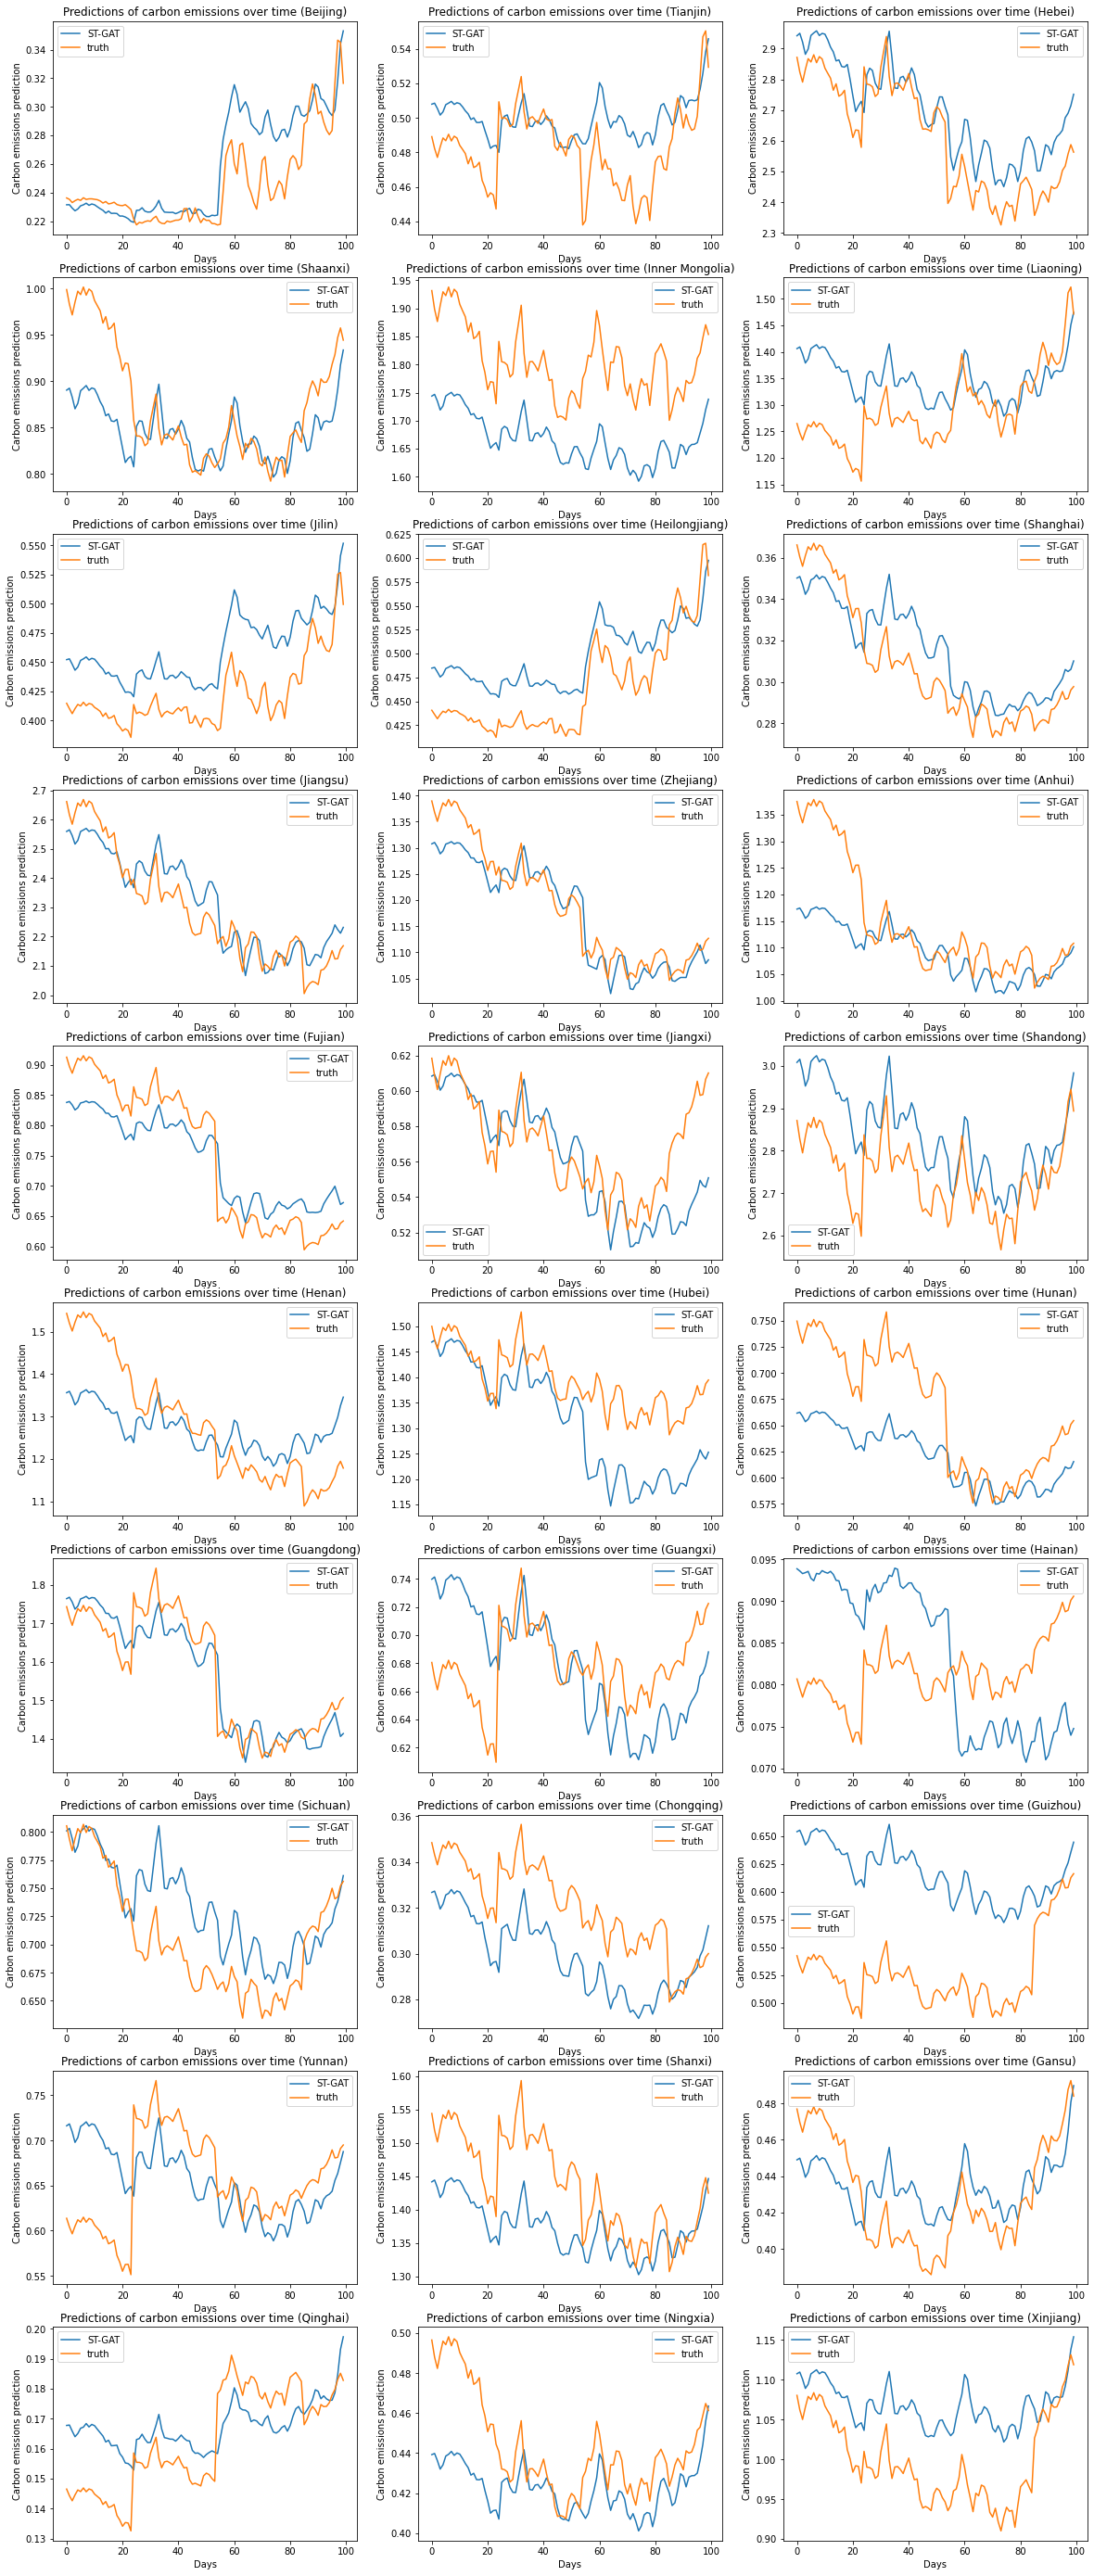

In [26]:
def plot_predictions(test_dataloader, y_pred, y_truth, node_names, config):
    s = y_truth.shape
    y_truth = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    
    fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 50))
    node = 0
    
    # Loop through each row and column and plot the corresponding node's predictions
    for row in range(10):
        for col in range(3):
            if node >= config['N_NODE']:
                break
            y_truth_node = y_truth[:, :, node, 0].flatten()[:100]
            y_pred_node = y_pred[:, :, node, 0].flatten()[:100]
            t = [t for t in range(0, 100, 1)]
            axes[row, col].plot(t, y_pred_node, label='ST-GAT')
            axes[row, col].plot(t, y_truth_node, label='truth')
            axes[row, col].set_xlabel('Days')
            axes[row, col].set_ylabel('Carbon emissions prediction')
            axes[row, col].set_title(f'Predictions of carbon emissions over time ({node_names[node]})')
            axes[row, col].legend()
            node += 1
    
    plt.show()
_, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')
plot_predictions(test_dataloader, y_pred, y_truth, node_names, config)

The above presents 30 figures depicting the 100-day carbon emission prediction performance. For some regions such as Beijing, Hebei, and Inner Mongolia etc., the first few days present good performance while the prediction deviates much from the ground truth later. For other regions including Heilongjiang, Jiangsu, Sichuan etc., the prediction is really bad.

Such bad performance has been expected before, since we spent most of our time collecting the data and pre-preprocessing it so that it can be read into the GNNs model which is quite different from other models in terms of inputs. The parameters are not optimized at all. Therefore, I think the prediction performance will be improved once starting to tune the model. 

# Bibliography <a class="anchor" id="ref"></a>

Zhang, C., Yu, J. J. Q., & Liu, Y. (2019). Spatial-Temporal Graph Attention Networks: A Deep Learning Approach for Traffic Forecasting. IEEE Access, 7, 166246–166256. https://doi.org/10.1109/ACCESS.2019.2953888

Cao, Q., Liang, Y., & Niu, X. (2017). China’s Air Quality and Respiratory Disease Mortality Based on the Spatial Panel Model. International Journal of Environmental Research and Public Health, 14(9), 1081. https://doi.org/10.3390/ijerph14091081

